<a href="https://colab.research.google.com/github/dkalenov/ML-Trading/blob/2_supervised-learning/Bitcoin_Move_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Case Study

Crypto exchanges (e.g. Bybit) allow customers to trade based on the size of Move for Bitcoin. If we can determine a model, which can forecast better than 50/50 accuracy, whether or not Bitcoins move will likely be above it's average, then we have an edge.

The catch is, how to predict whether future volatility will be above or below the rolling average (assuming that the rolling average is where the market adjusts to). Regardless, this will be a significant challenge and we will need state-of-the-art methods, whilst making sure we do not overfit.

## Data_Preprocessing

### Imports

In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=778068132ca07d4144e40e1e889aae7994c2eaaa336b5d6e243a577ef8950513
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import numpy as np
import pandas as pd
import sklearn.mixture as mix
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'ta'

In [ ]:
 !pip install pandas-datareader

### Data Extraction and Returns Overview

In [ ]:
import numpy as np
import yfinance as yf

# Create the class
class StrategyManager():

    # Initialize the class
    def __init__(self, symbol, start_date, end_date):
        self.df = self._extract_data(symbol, start_date, end_date)
        self.sharpe = 0

    # Extract data
    def _extract_data(self, symbol, start_date, end_date):
        from pandas_datareader.data import DataReader
        data = yf.download(symbol, start_date, end_date)
        #data = DataReader(name=symbol, data_source='yahoo', start=start_date, end=end_date)
        data = data[["Open", "High", "Low", "Close", "Volume"]]
        data = self._structure_df(data)
        return data

    # Calculates general period returns and volatility
    def _structure_df(self, df):
        df["Returns"] = df["Close"].pct_change()
        df["Range"] = df["High"] / df["Low"] - 1
        df["Bench_C_Rets"], sharpe = self._calculate_returns(df, True)
        self.sharpe = sharpe
        df.dropna(inplace=True)
        return df

    # Adjusts the signal to represent our strategy
    def _set_multiplier(self, direction):
        if direction == "long":
            pos_multiplier = 1
            neg_multiplier = 0
        elif direction == "long_short":
            pos_multiplier = 1
            neg_multiplier = -1
        else:
            pos_multiplier = 0
            neg_multiplier = -1
        return pos_multiplier, neg_multiplier

    # Calculates returns for equity curve
    def _calculate_returns(self, df, is_benchmark):

        # Calculate multiplier
        if not is_benchmark:
            multiplier_1 = df["Signal"]
            multiplier_2 = 1 if "PSignal" not in df.columns else df["PSignal"]
            log_rets = np.log(df["Close"] / df["Close"].shift(1)) * multiplier_1 * multiplier_2
        else:
            multiplier_1 = 1
            multiplier_2 = 1

            # Assume open price on following day to avoid lookahead bias for close calculation
            log_rets = np.log(df["Open"].shift(-1) / df["Close"].shift(1)) * multiplier_1 * multiplier_2

        # Calculate Sharpe Ratio
        sharpe_ratio = self.sharpe_ratio(log_rets)

        # Calculate Cumulative Returns
        c_log_rets = log_rets.cumsum()
        c_log_rets_exp = np.exp(c_log_rets) - 1

        # Return result and Sharpe ratio
        return c_log_rets_exp, sharpe_ratio

    def sharpe_ratio(self, return_series):
        N = 255 # Trading days in the year (change to 365 for crypto)
        rf = 0.005 # Half a percent risk free rare
        mean = return_series.mean() * N -rf
        sigma = return_series.std() * np.sqrt(N)
        sharpe = round(mean / sigma, 3)
        return sharpe

    # Replace Dataframe
    def change_df(self, new_df, drop_cols=[]):
        new_df = new_df.drop(columns=drop_cols)
        self.df = new_df

    # Moving average crossover strategy
    def backtest_ma_crossover(self, period_1, period_2, direction, drop_cols=[]):

        # Set df
        df = self.df

        # Get multipliers
        pos_multiplier, neg_multiplier = self._set_multiplier(direction)

        # Calculate Moving Averages
        if f"MA_{period_1}" or f"MA_{period_2}" not in df.columns:
            df[f"MA_{period_1}"] = df["Close"].rolling(window=period_1).mean()
            df[f"MA_{period_2}"] = df["Close"].rolling(window=period_2).mean()
            df.dropna(inplace=True)

        # Calculate Benchmark Returns
        df["Bench_C_Rets"], sharpe_ratio_bench = self._calculate_returns(df, True)

        # Calculate Signal
        df.loc[df[f"MA_{period_1}"] > df[f"MA_{period_2}"], "Signal"] = pos_multiplier
        df.loc[df[f"MA_{period_1}"] <= df[f"MA_{period_2}"], "Signal"] = neg_multiplier

        # Calculate Strategy Returns
        df["Strat_C_Rets"], sharpe_ratio_strat = self._calculate_returns(df, False)

        # Get values for output
        bench_rets = df["Bench_C_Rets"].values.astype(float)
        strat_rets = df["Strat_C_Rets"].values.astype(float)
        print("Sense check: ", round(df["Close"].values[-1] / df["Close"].values[0] - 1, 3), round(bench_rets[-1], 3))

        # Remove irrelevant features
        if len(drop_cols) > 0:
            df = df.drop(columns=drop_cols)

        # Ensure Latest DF matches
        df = df.dropna()
        self.df = df

        # Return df
        return df, sharpe_ratio_bench, sharpe_ratio_strat

In [ ]:
# Extract Data
start_date = "2017-01-01"
end_date = "2024-03-31"
symbol = "BTC-USD"
strat_mgr = StrategyManager(symbol, start_date, end_date)
df = strat_mgr.df.copy()
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets
Date,,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803,0.023314
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005,0.045999
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130,0.159122
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,-0.122410,0.308302,0.018098
2017-01-06,1014.239990,1046.810059,883.943970,902.200989,351876000,-0.109711,0.184249,-0.092307


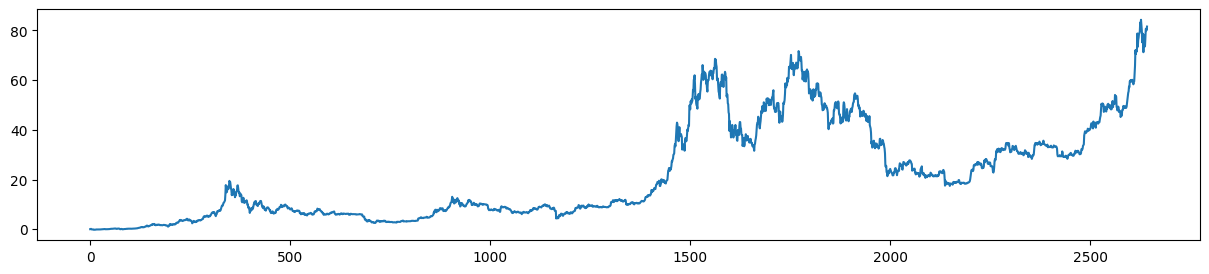

In [ ]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 3))
plt.plot(df["Bench_C_Rets"].values)
plt.show()

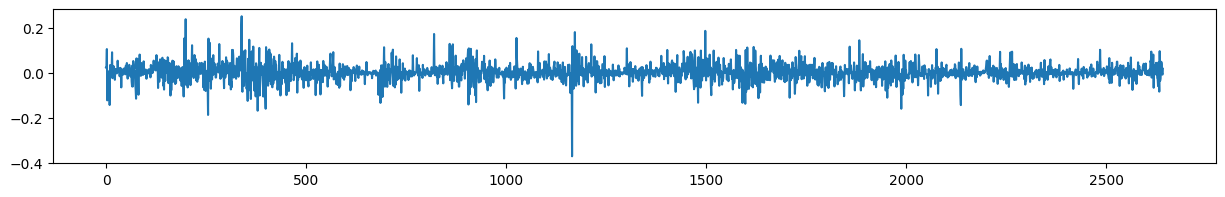

In [ ]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Returns"].values)
plt.show()

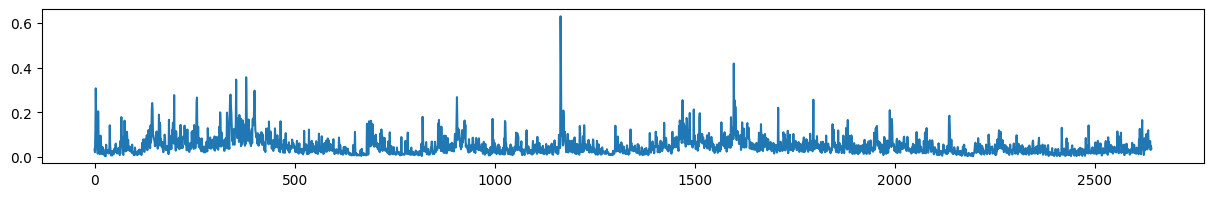

In [ ]:
# Benchmark Range Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Range"].values)
plt.show()

### Feature Engineering - Feature Expansion

In [ ]:
# Create a copy
df_fe = df.copy()

##### Indicators

In [ ]:
# Add RSI(Relative Strength Index) RSI helps to assess the level of overbought or oversold an asset and the expected strength of the current trend.
rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi
df_fe["RSI_Ret"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

In [ ]:
# Add Moving Average
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

In [ ]:
# Day of Week
df_fe["DOW"] = df_fe.index.dayofweek

In [ ]:
# Rolling Cumulative Returns
df_fe["Roll_Rets"] = df_fe["Returns"].rolling(window=30).sum()

In [ ]:
# Rolling Cumulative Range
df_fe["Avg_Range"] = df_fe["Range"].rolling(window=30).mean()

##### Time Intervals

In [ ]:
# Add Time Intervals
t_steps = [1, 2]
t_features = ["Returns", "Range", "RSI_Ret"]
for ts in t_steps:
    for tf in t_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

In [ ]:
# Show DataFrame
df_fe.head(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803,0.023314,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005,0.045999,NaN,NaN,...,NaN,1,NaN,NaN,0.023464,0.034803,NaN,NaN,NaN,NaN
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130,0.159122,NaN,NaN,...,NaN,2,NaN,NaN,0.021620,0.022005,NaN,0.023464,0.034803,NaN


### Feature Engineering - Feature Scaling

In [ ]:
# Correct for Stationarity
df_fs = df_fe.copy()
df_fs[["Open", "High", "Low", "Volume"]] = df_fs[["Open", "High", "Low", "Volume"]].pct_change()
df_fs

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,NaN,NaN,1021.750000,NaN,0.023464,0.034803,0.023314,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,0.023015,0.012304,0.024980,1043.839966,-0.166604,0.021620,0.022005,0.045999,NaN,NaN,...,NaN,1,NaN,NaN,0.023464,0.034803,NaN,NaN,NaN,NaN
2017-01-04,0.022318,0.110471,0.022318,1154.729980,0.862881,0.106233,0.110130,0.159122,NaN,NaN,...,NaN,2,NaN,NaN,0.021620,0.022005,NaN,0.023464,0.034803,NaN
2017-01-05,0.107555,0.027324,-0.128287,1013.380005,0.479069,-0.122410,0.308302,0.018098,NaN,NaN,...,NaN,3,NaN,NaN,0.106233,0.110130,NaN,0.021620,0.022005,NaN
2017-01-06,-0.123183,-0.121140,-0.029078,902.200989,-0.310316,-0.109711,0.184249,-0.092307,NaN,NaN,...,NaN,4,NaN,NaN,-0.122410,0.308302,NaN,0.106233,0.110130,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-24,0.004201,0.024954,0.012490,67234.171875,0.099748,0.049514,0.059489,77.455751,55.088041,1.102233,...,67624.716146,6,0.310708,0.063045,0.004444,0.046605,1.009630,-0.026150,0.068452,0.946531
2024-03-25,0.049373,0.052347,0.040563,69958.812500,0.569475,0.040525,0.071486,80.603071,58.965394,1.070385,...,67702.258929,0,0.334692,0.064704,0.049514,0.059489,1.102233,0.004444,0.046605,1.009630
2024-03-26,0.040117,0.005244,0.043978,69987.835938,-0.156667,0.000415,0.031732,80.641663,59.005994,1.000689,...,67996.860677,1,0.331963,0.065344,0.040525,0.071486,1.070385,0.049514,0.059489,1.102233


### Assess Data for ML Readiness

In [ ]:
# Check for NaN
df_fs.dropna(inplace=True)
print(df_fs.isnull().values.any())

False


In [ ]:
# Check for Inf values
dfobj = df_fs.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()
count

0

In [ ]:
# Check for non-numerical objects
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2614 entries, 2017-01-31 to 2024-03-28
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2614 non-null   float64
 1   High          2614 non-null   float64
 2   Low           2614 non-null   float64
 3   Close         2614 non-null   float64
 4   Volume        2614 non-null   float64
 5   Returns       2614 non-null   float64
 6   Range         2614 non-null   float64
 7   Bench_C_Rets  2614 non-null   float64
 8   RSI           2614 non-null   float64
 9   RSI_Ret       2614 non-null   float64
 10  MA_12         2614 non-null   float64
 11  MA_21         2614 non-null   float64
 12  DOW           2614 non-null   int64  
 13  Roll_Rets     2614 non-null   float64
 14  Avg_Range     2614 non-null   float64
 15  Returns_T1    2614 non-null   float64
 16  Range_T1      2614 non-null   float64
 17  RSI_Ret_T1    2614 non-null   float64
 18  Returns_T2

In [ ]:
# Describe DataFrame
df_fs.describe()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
count,2614.000000,2614.000000,2614.000000,2614.000000,2614.000000,2614.000000,2614.000000,2614.000000,2614.000000,2614.000000,...,2614.000000,2614.000000,2614.000000,2614.000000,2614.000000,2614.000000,2614.000000,2614.000000,2614.000000,2614.000000
mean,0.002392,0.002225,0.002401,20570.661663,0.042163,0.002400,0.049831,22.172225,53.410679,1.005278,...,20314.297529,2.998852,0.071485,0.049693,0.002394,0.049818,1.005267,0.002396,0.049801,1.005270
std,0.038289,0.033657,0.038263,17076.285176,0.322049,0.038292,0.042349,19.394730,14.514658,0.104737,...,16766.837246,1.999713,0.233577,0.023662,0.038291,0.042358,0.104735,0.038290,0.042367,0.104735
min,-0.365924,-0.263712,-0.364062,937.520020,-0.869188,-0.371695,0.003596,-0.044698,9.920239,0.453659,...,885.613522,0.000000,-0.844981,0.015756,-0.371695,0.003596,0.453659,-0.371695,0.003596,0.453659
25%,-0.013747,-0.011246,-0.011122,7147.675781,-0.133890,-0.013857,0.023224,6.700325,43.213135,0.955223,...,7162.708217,1.000000,-0.069554,0.033321,-0.013857,0.023184,0.955223,-0.013857,0.023156,0.955223
50%,0.001380,-0.000191,0.002897,11960.320312,-0.006861,0.001388,0.038561,11.836185,52.335733,1.004138,...,11712.418945,3.000000,0.044631,0.043822,0.001377,0.038561,1.004029,0.001377,0.038545,1.004029
75%,0.018667,0.014465,0.017024,30973.604492,0.163143,0.018535,0.061022,34.460433,63.015842,1.047106,...,30490.382394,5.000000,0.222743,0.059009,0.018484,0.061022,1.047106,0.018484,0.061022,1.047106
max,0.250461,0.245708,0.247892,73083.500000,5.439003,0.252472,0.631387,84.255882,94.302215,1.926078,...,68338.194382,6.000000,1.154731,0.138628,0.252472,0.631387,1.926078,0.252472,0.631387,1.926078


### Save Data

In [ ]:
# Save DataFrame
import os

if not os.path.exists('data'):
    os.makedirs('data')

df_fs.to_csv(f"data/{symbol}.csv")

## Model Training


### Imports

In [1]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

#### Import Preprocessed Data

In [2]:
# df = pd.read_csv("data/BTC-USD.csv")
# df.set_index("Date", inplace=True)
# df.head(3)

In [3]:
url = 'https://raw.githubusercontent.com/dkalenov/ML-Trading/2_supervised-learning/BTC-USD.csv'

df = pd.read_csv(url)
df.set_index("Date", inplace=True)
df.head()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,0.000878,0.053054,0.001615,970.403015,1.103895,0.054348,0.055442,-0.029463,60.205366,1.192634,...,885.613522,1,0.011408,0.057910,0.000964,0.003887,1.003974,-0.002272,0.004646,0.991144
2017-02-01,0.054272,0.017587,0.054056,989.023010,-0.087932,0.019188,0.018926,-0.009863,63.109498,1.048237,...,895.673808,2,0.007132,0.057381,0.054348,0.055442,1.192634,0.000964,0.003887,1.003974
2017-02-02,0.019630,0.024675,0.012855,1011.799988,-0.028572,0.023030,0.030816,0.012600,66.345006,1.051268,...,905.529332,3,0.008542,0.057675,0.019188,0.018926,1.048237,0.054348,0.055442,1.192634
2017-02-03,0.021676,0.020079,0.026005,1029.910034,0.380309,0.017899,0.024861,0.032145,68.695922,1.035435,...,915.335333,4,-0.079792,0.054832,0.023030,0.030816,1.051268,0.019188,0.018926,1.048237
2017-02-04,0.019645,0.011636,0.006314,1042.900024,-0.229603,0.012613,0.030281,0.045785,70.298572,1.023330,...,926.025239,5,0.055230,0.045565,0.017899,0.024861,1.035435,0.023030,0.030816,1.051268


#### Add Prediction Target

In [4]:
# Specify Target
df.loc[df["Range"].shift(-1) > df["Avg_Range"], "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["Avg_Range"], "TARGET"] = 0

In [5]:
# Check for NaNs
nan_location = np.where(np.isnan(df))
nan_location

(array([2613]), array([21]))

In [6]:
# Fill NA
df["TARGET"].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-24,0.004201,0.024954,0.012490,67234.171875,0.099748,0.049514,0.059489,77.455751,55.088041,1.102233,...,6,0.310708,0.063045,0.004444,0.046605,1.009630,-0.026150,0.068452,0.946531,1.0
2024-03-25,0.049373,0.052347,0.040563,69958.812500,0.569475,0.040525,0.071486,80.603071,58.965394,1.070385,...,0,0.334692,0.064704,0.049514,0.059489,1.102233,0.004444,0.046605,1.009630,0.0
2024-03-26,0.040117,0.005244,0.043978,69987.835938,-0.156667,0.000415,0.031732,80.641663,59.005994,1.000689,...,1,0.331963,0.065344,0.040525,0.071486,1.070385,0.049514,0.059489,1.102233,0.0
2024-03-27,0.000866,0.002683,-0.013755,69455.343750,0.133758,-0.007608,0.048928,80.017507,57.874623,0.980826,...,2,0.270440,0.064352,0.000415,0.031732,1.000689,0.040525,0.071486,1.070385,0.0
2024-03-28,-0.007703,-0.002533,0.007510,70744.953125,-0.158037,0.018567,0.038472,81.521614,59.880894,1.034666,...,3,0.242000,0.063766,-0.007608,0.048928,0.980826,0.000415,0.031732,1.000689,0.0


#### Train Test Split

In [7]:
# Remove unwanted columns
df_tts = df.copy()
df_tts.drop(columns=["Close", "Bench_C_Rets", "Open", "High", "Low"], inplace=True)

In [8]:
df_tts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2614 entries, 2017-01-31 to 2024-03-28
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Volume      2614 non-null   float64
 1   Returns     2614 non-null   float64
 2   Range       2614 non-null   float64
 3   RSI         2614 non-null   float64
 4   RSI_Ret     2614 non-null   float64
 5   MA_12       2614 non-null   float64
 6   MA_21       2614 non-null   float64
 7   DOW         2614 non-null   int64  
 8   Roll_Rets   2614 non-null   float64
 9   Avg_Range   2614 non-null   float64
 10  Returns_T1  2614 non-null   float64
 11  Range_T1    2614 non-null   float64
 12  RSI_Ret_T1  2614 non-null   float64
 13  Returns_T2  2614 non-null   float64
 14  Range_T2    2614 non-null   float64
 15  RSI_Ret_T2  2614 non-null   float64
 16  TARGET      2614 non-null   float64
dtypes: float64(16), int64(1)
memory usage: 367.6+ KB


In [9]:
# Split into Learning (X) and Target (y) Data
X = df_tts.drop('TARGET', axis=1)
y = df_tts['TARGET']

In [10]:
# Perform Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

Shape of X_train:  (2091, 16)
Shape of y_train:  (2091,)


### Build Initial Model

In [ ]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [ ]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [ ]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report




models = {
     'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced'),
     'RandomForestClassifier': RandomForestClassifier(class_weight='balanced'),
     'LGBMClassifier': LGBMClassifier(class_weight='balanced'),
     'XGBClassifier': XGBClassifier(class_weight='balanced'),
     'GradientBoostingClassifier': GradientBoostingClassifier(),
     'LogisticRegression': LogisticRegression()
     }


for name, model in models.items():
     print(f'Using model: {name}')
     model.fit(X_train, y_train)
     #Making a prediction for the training set
     y_train_predict = model.predict(X_train)
     #Making a prediction for the test sample
     y_test_predict = model.predict(X_test)

     print(f"Training: {classification_report(y_train, y_train_predict)}")
     print(f"\n: {classification_report(y_test, y_test_predict)}")
     print('*'*30)
     print()

Using model: DecisionTreeClassifier
Training:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1317
         1.0       1.00      1.00      1.00       774

    accuracy                           1.00      2091
   macro avg       1.00      1.00      1.00      2091
weighted avg       1.00      1.00      1.00      2091


:               precision    recall  f1-score   support

         0.0       0.67      0.70      0.68       329
         1.0       0.44      0.41      0.43       194

    accuracy                           0.59       523
   macro avg       0.56      0.55      0.55       523
weighted avg       0.58      0.59      0.59       523

******************************

Using model: RandomForestClassifier
Training:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1317
         1.0       1.00      1.00      1.00       774

    accuracy                           1.00      2091
 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:18:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1317
         1.0       1.00      1.00      1.00       774

    accuracy                           1.00      2091
   macro avg       1.00      1.00      1.00      2091
weighted avg       1.00      1.00      1.00      2091


:               precision    recall  f1-score   support

         0.0       0.70      0.77      0.74       329
         1.0       0.54      0.45      0.49       194

    accuracy                           0.65       523
   macro avg       0.62      0.61      0.61       523
weighted avg       0.64      0.65      0.64       523

******************************

Using model: GradientBoostingClassifier
Training:               precision    recall  f1-score   support

         0.0       0.79      0.96      0.86      1317
         1.0       0.88      0.56      0.68       774

    accuracy                           0.81      2091
   macro avg       0.83      0.76

In [ ]:
from sklearn.metrics import classification_report

# Model definition and training
model = XGBClassifier()
model.fit(X_train, y_train)


# Prediction on train and test data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# evoluating
report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)

print('Train:\n', report_train)
print('\n\nTest:\n', report_test)

Train:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1317
         1.0       1.00      1.00      1.00       774

    accuracy                           1.00      2091
   macro avg       1.00      1.00      1.00      2091
weighted avg       1.00      1.00      1.00      2091



Test:
               precision    recall  f1-score   support

         0.0       0.70      0.77      0.74       329
         1.0       0.54      0.45      0.49       194

    accuracy                           0.65       523
   macro avg       0.62      0.61      0.61       523
weighted avg       0.64      0.65      0.64       523



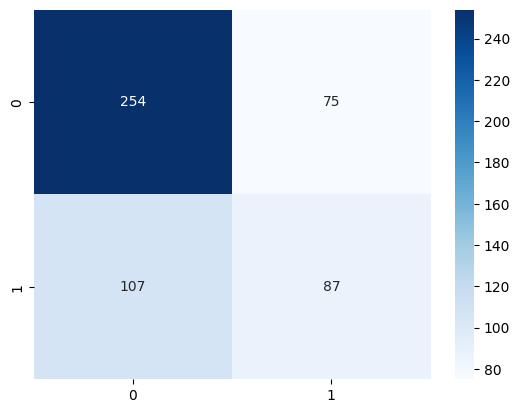

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_train = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.show()

The model is overtrained

#### Find Hyperparameters (HyperOpt)

In [ ]:
# from hyperopt import fmin, tpe, hp, Trials
# import numpy as np
# from sklearn.model_selection import cross_val_score
# from xgboost import XGBClassifier

# space = {
#     'n_estimators': hp.choice('n_estimators', range(50, 201)),
#     'learning_rate': hp.uniform('learning_rate', 0.001, 0.9),
#     'max_depth': hp.choice('max_depth', range(3, 15)),
#     'min_child_weight': hp.choice('min_child_weight', range(1, 6)),
#     'subsample': hp.uniform('subsample', 0.5, 1.0),
#     'gamma': hp.uniform('gamma', 0, 20),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
#     'reg_alpha': hp.uniform('reg_alpha', 0, 10),
#     'reg_lambda': hp.uniform('reg_lambda', 0, 10),
# }

# def hyperopt_xgb(params, cv=5, X=X_train_scaled, y=y_train):
#     model = XGBClassifier(**params)
#     model.fit(X, y)
#     score = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()
#     return -score

# trials = Trials()
# best = fmin(hyperopt_xgb,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=100,
#             trials=trials,
#             rstate=np.random.default_rng(42)
#            )

# print(f"Best hyperparameter values: {best}")

In [ ]:
from hyperopt import fmin, tpe, hp, Trials
import numpy as np
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'max_depth': hp.choice('max_depth', range(4, 15)),
    'gamma': hp.uniform('gamma', 0, 20),
}

def hyperopt_xgb(params, cv=5, X=X_train, y=y_train):
    model = XGBClassifier(**params)
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    return -score

trials = Trials()
best = fmin(hyperopt_xgb,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42)
           )

print(f"Best hyperparameter values: {best}")

100%|██████████| 100/100 [02:11<00:00,  1.32s/trial, best loss: -0.5134586208979626]
Best hyperparameter values: {'gamma': 0.19689456859671273, 'learning_rate': 0.30767954799721714, 'max_depth': 1, 'n_estimators': 109}


In [ ]:
# Let's continue to look for the most optimal parameters

best = fmin(hyperopt_xgb,  # our function
            space=space,  # hyperparameter space
            algo=tpe.suggest,  # optimization algorithm, set by default, not required to specify
            max_evals=300,  # maximum number of iterations
            trials=trials,  # logging results
            rstate=np.random.default_rng(42)  # set for result reproducibility
           )
print(f"Best hyperparameter values: {best}")

100%|██████████| 300/300 [03:20<00:00,  1.00s/trial, best loss: -0.5192294683728071]
Best hyperparameter values: {'gamma': 0.3311792374794735, 'learning_rate': 0.32669156290697077, 'max_depth': 2, 'n_estimators': 120}


In [ ]:
# from xgboost import XGBClassifier

# best_params = {
#     'n_estimators': best['n_estimators'],
#     'learning_rate': best['learning_rate'],
#     'max_depth': best['max_depth'],
#     'min_child_weight': best['min_child_weight'],
#     'subsample': best['subsample'],
#     'gamma': best['gamma'],
#     'colsample_bytree': best['colsample_bytree'],
#     'reg_alpha': best['reg_alpha'],
#     'reg_lambda': best['reg_lambda']
# }

# xgb = XGBClassifier(**best_params)

#### Training

In [ ]:
from xgboost import XGBClassifier

best_params = {
    'n_estimators': best['n_estimators'],
    'learning_rate': best['learning_rate'],
    'max_depth': best['max_depth'],
    'gamma': best['gamma'],

}

xgb = XGBClassifier(**best_params)

In [ ]:
from sklearn import model_selection

# Performing cross-validation and obtaining predictions for the training set
y_pred_train= model_selection.cross_val_predict(estimator=xgb, X=X_train, y=y_train, cv=5)

# Performing cross-validation and obtaining predictions for the test set
y_pred_test = model_selection.cross_val_predict(estimator=xgb, X=X_test, y=y_test, cv=5)


# evoluating
report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)

print('Train:\n', report_train)
print('\n\nTest:\n', report_test)

Train:
               precision    recall  f1-score   support

         0.0       0.70      0.87      0.78      1317
         1.0       0.63      0.37      0.46       774

    accuracy                           0.68      2091
   macro avg       0.66      0.62      0.62      2091
weighted avg       0.67      0.68      0.66      2091



Test:
               precision    recall  f1-score   support

         0.0       0.70      0.83      0.76       329
         1.0       0.58      0.39      0.46       194

    accuracy                           0.67       523
   macro avg       0.64      0.61      0.61       523
weighted avg       0.65      0.67      0.65       523



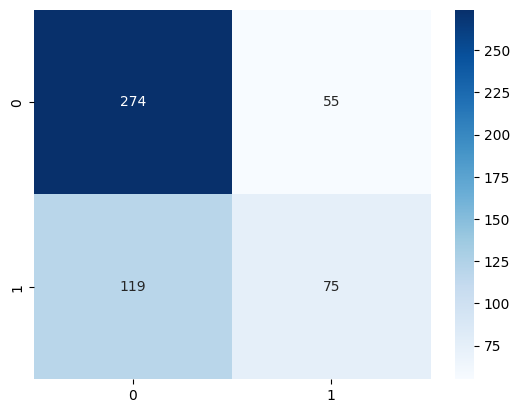

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_train = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
xgb.fit(X_train, y_train)


# Prediction on train and test data
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

# evoluating
report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)

print('Train:\n', report_train)
print('\n\nTest:\n', report_test)

Train:
               precision    recall  f1-score   support

         0.0       0.72      0.90      0.80      1317
         1.0       0.71      0.42      0.53       774

    accuracy                           0.72      2091
   macro avg       0.72      0.66      0.67      2091
weighted avg       0.72      0.72      0.70      2091



Test:
               precision    recall  f1-score   support

         0.0       0.69      0.87      0.77       329
         1.0       0.61      0.35      0.45       194

    accuracy                           0.68       523
   macro avg       0.65      0.61      0.61       523
weighted avg       0.66      0.68      0.65       523



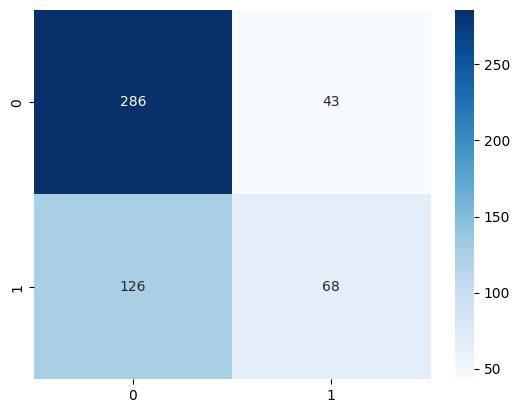

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_train = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.show()

### Feature Selection

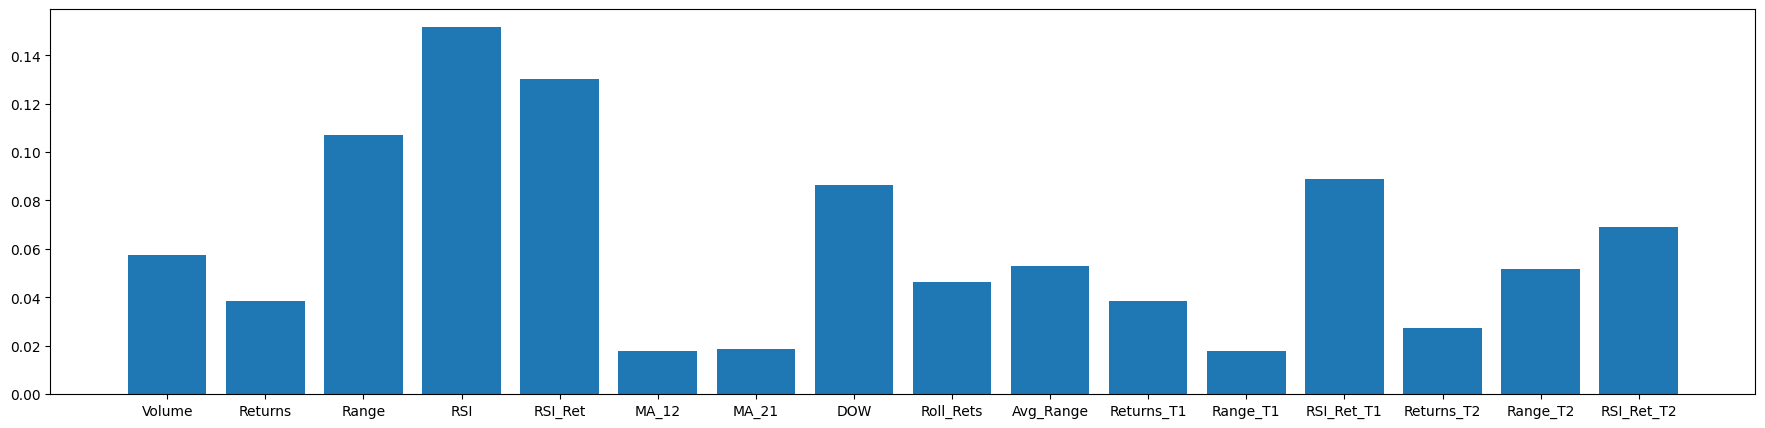

In [ ]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = xgb.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

In [ ]:
# Select Best Features
mean_feature_importance = importance_features.mean()
i = 0
recommended_feature_labels = []
recommended_feature_score = []
for fi in importance_features:
    if fi > mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)
    i += 1

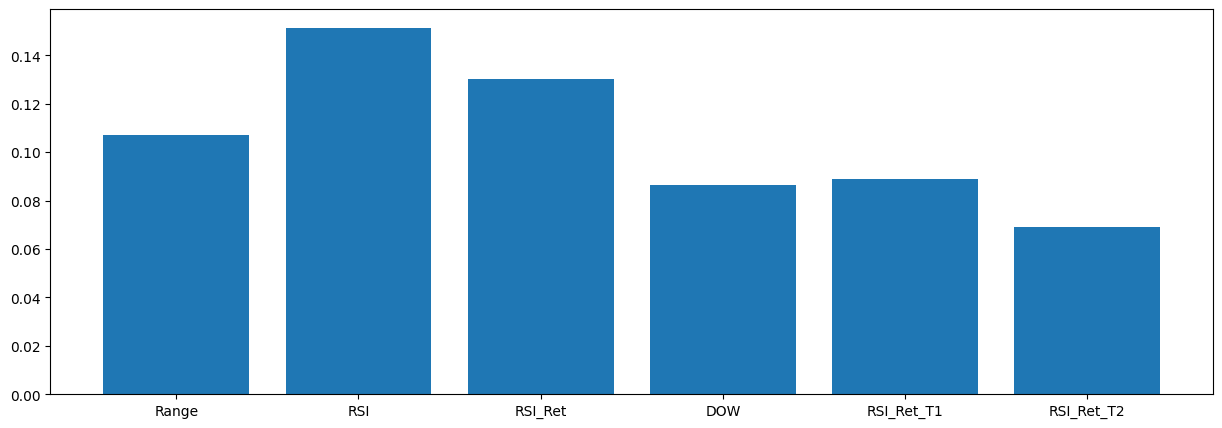

In [ ]:
# Plot Recommended Features
fig = plt.figure(figsize=(15, 5))
plt.bar(recommended_feature_labels, recommended_feature_score)
plt.show()

In [ ]:
recommended_feature_labels

['Range', 'RSI', 'RSI_Ret', 'DOW', 'RSI_Ret_T1', 'RSI_Ret_T2']

### Fearure Selection Training

#### Train Test Split

In [ ]:
# Feature Selection
df_tts = df.copy()
df_tts = df_tts[["Returns", "Range", "RSI", "RSI_Ret", "Returns_T1", "RSI_Ret_T1", "TARGET"]]

In [ ]:
df_tts.head()

,Returns,Range,RSI,RSI_Ret,Returns_T1,RSI_Ret_T1,TARGET
Date,,,,,,,
2017-01-31,0.054348,0.055442,60.205366,1.192634,0.000964,1.003974,0.0
2017-02-01,0.019188,0.018926,63.109498,1.048237,0.054348,1.192634,0.0
2017-02-02,0.023030,0.030816,66.345006,1.051268,0.019188,1.048237,0.0
2017-02-03,0.017899,0.024861,68.695922,1.035435,0.023030,1.051268,0.0
2017-02-04,0.012613,0.030281,70.298572,1.023330,0.017899,1.035435,0.0


In [ ]:
# Split into Learning (X) and Target (y) Data
X = df_tts.drop('TARGET', axis=1)
y = df_tts['TARGET']

In [ ]:
# Perform Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (1960, 6)
Shape of y_train:  (1960,)
Shape of X_test:  (654, 6)
Shape of y_test:  (654,)
Size Matches:  True


#### Find Hyperparameters (HyperOpt)

In [ ]:
from hyperopt import fmin, tpe, hp, Trials
import numpy as np
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201)),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.9),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_child_weight': hp.choice('min_child_weight', range(1, 6)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 20),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
}

def hyperopt_xgb(params, cv=5, X=X_train, y=y_train):
    model = XGBClassifier(**params)
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    return -score

trials = Trials()
best = fmin(hyperopt_xgb,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42)
           )

print(f"Best hyperparameter values: {best}")

100%|██████████| 100/100 [00:38<00:00,  2.59trial/s, best loss: -0.4526773330553559]
Best hyperparameter values: {'colsample_bytree': 0.8500731284565011, 'gamma': 6.808694129963962, 'learning_rate': 0.869368338638988, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 127, 'reg_alpha': 1.058075851365467, 'reg_lambda': 6.508444503501201, 'subsample': 0.5120923232060155}


In [ ]:
from hyperopt import fmin, tpe, hp, Trials
import numpy as np
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'max_depth': hp.choice('max_depth', range(4, 15)),
    'gamma': hp.uniform('gamma', 0, 20),
}

def hyperopt_xgb(params, cv=5, X=X_train, y=y_train):
    model = XGBClassifier(**params)
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    return -score

trials = Trials()
best = fmin(hyperopt_xgb,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42)
           )

print(f"Best hyperparameter values: {best}")

100%|██████████| 100/100 [00:41<00:00,  2.40trial/s, best loss: -0.4349856551390451]
Best hyperparameter values: {'gamma': 2.778472377527666, 'learning_rate': 0.34264577740016827, 'max_depth': 9, 'n_estimators': 35}


In [ ]:
# Let's continue to look for the most optimal parameters

best = fmin(hyperopt_xgb,  # our function
            space=space,  # hyperparameter space
            algo=tpe.suggest,  # optimization algorithm, set by default, not required to specify
            max_evals=300,  # maximum number of iterations
            trials=trials,  # logging results
            rstate=np.random.default_rng(42)  # set for result reproducibility
           )
print(f"Best hyperparameter values: {best}")

100%|██████████| 300/300 [01:19<00:00,  2.53trial/s, best loss: -0.4526773330553559]
Best hyperparameter values: {'colsample_bytree': 0.8500731284565011, 'gamma': 6.808694129963962, 'learning_rate': 0.869368338638988, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 127, 'reg_alpha': 1.058075851365467, 'reg_lambda': 6.508444503501201, 'subsample': 0.5120923232060155}


#### Training

In [ ]:
from xgboost import XGBClassifier

best_params = {
    'n_estimators': best['n_estimators'],
    'learning_rate': best['learning_rate'],
    'max_depth': best['max_depth'],
    'min_child_weight': best['min_child_weight'],
    'subsample': best['subsample'],
    'gamma': best['gamma'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda']
}

xgb = XGBClassifier(**best_params)

In [ ]:
# from xgboost import XGBClassifier

# best_params = {
#     'n_estimators': best['n_estimators'],
#     'learning_rate': best['learning_rate'],
#     'max_depth': best['max_depth'],
#     'gamma': best['gamma'],

# }

# xgb_s = XGBClassifier(**best_params)

In [ ]:
from sklearn import model_selection
from sklearn.metrics import classification_report

# Performing cross-validation and obtaining predictions for the training set
y_pred_train= model_selection.cross_val_predict(estimator=xgb, X=X_train, y=y_train, cv=5)

# Performing cross-validation and obtaining predictions for the test set
y_pred_test = model_selection.cross_val_predict(estimator=xgb, X=X_test, y=y_test, cv=5)


# evoluating
report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)

print('Train:\n', report_train)
print('\n\nTest:\n', report_test)

Train:
               precision    recall  f1-score   support

         0.0       0.69      0.84      0.76      1241
         1.0       0.56      0.36      0.44       719

    accuracy                           0.66      1960
   macro avg       0.63      0.60      0.60      1960
weighted avg       0.65      0.66      0.64      1960



Test:
               precision    recall  f1-score   support

         0.0       0.66      0.80      0.72       405
         1.0       0.50      0.33      0.40       249

    accuracy                           0.62       654
   macro avg       0.58      0.56      0.56       654
weighted avg       0.60      0.62      0.60       654



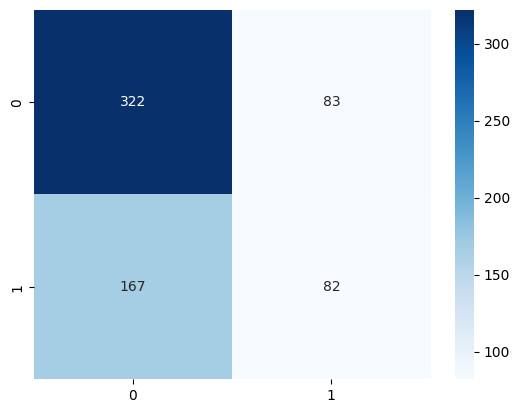

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_train = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
xgb.fit(X_train, y_train)


# Prediction on train and test data
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

# evoluating
report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)

print('Train:\n', report_train)
print('\n\nTest:\n', report_test)

Train:
               precision    recall  f1-score   support

         0.0       0.71      0.85      0.77      1241
         1.0       0.61      0.42      0.50       719

    accuracy                           0.69      1960
   macro avg       0.66      0.63      0.64      1960
weighted avg       0.68      0.69      0.67      1960



Test:
               precision    recall  f1-score   support

         0.0       0.69      0.82      0.75       405
         1.0       0.57      0.39      0.46       249

    accuracy                           0.65       654
   macro avg       0.63      0.60      0.60       654
weighted avg       0.64      0.65      0.64       654

